<a href="https://colab.research.google.com/github/PaoVale/FellTrack/blob/main/FeelTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Setup and Import Libraries
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download nltk duct utils
nltk.data.path.append('/usr/share/nltk_data')
nltk.download('stopwords', '/usr/share/nltk_data')
nltk.download('wordnet', '/usr/share/nltk_data')
nltk.download('punkt', '/usr/share/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/share/nltk_data')
!yes | unzip -q /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Setting the style for seaborn
sns.set(style='whitegrid')

# To suppress warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Set verbosity during model trainig
verbose = True

# Dataset

### Dataset Loading

In [ ]:
# Load training dataset part 1
train_pt1 = pd.read_csv('Train.csv')

# Drop not used columns
train_pt1 = train_pt1.drop(columns=['Id'], axis=1)

# Load training dataset part 1
train_pt2 = pd.read_csv('Twitter_Data.csv')

# Rename columns
train_pt2 = train_pt2.rename(columns={"clean_text": "Body", "category": "Sentiment Type"})

# Replace values to match lables of part 1
train_pt2 = train_pt2.replace(-1, "negative")
train_pt2 = train_pt2.replace(0, "neutral")
train_pt2 = train_pt2.replace(1, "positive")

# Concat the two parts to get the final training set
train = pd.concat([train_pt1, train_pt2], ignore_index=True, sort=False).reset_index(drop=True)


# Load test dataset
test  = pd.read_csv('synthetic_social_media_data.csv')

In [ ]:
# Display first few rows of training set
print("Training Dataset:")
print(train.head())

In [ ]:
# Display first few rows of test set
print("\nTest Dataset:")
print(test.head())

In [ ]:
# Missing Values in Training Dataset
train.isnull().sum()

In [ ]:
# Class distribution
train['Sentiment Type'].value_counts()

## Dataset Preprocessing

In [ ]:
# Drop rows where any column has missing values
train = train.dropna()
test = test.dropna()

In [ ]:
# Plotting class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Sentiment Type', palette='viridis')
plt.title('Sentiment Type Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Remove contractions
def contractions(s):
    s = re.sub(r"won't", "will not", s, flags=re.IGNORECASE)
    s = re.sub(r"wouldn't", "would not", s, flags=re.IGNORECASE)
    s = re.sub(r"couldn't", "could not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’d", " would", s, flags=re.IGNORECASE)
    s = re.sub(r"can't", "can not", s, flags=re.IGNORECASE)
    s = re.sub(r"n’t", " not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’re", " are", s, flags=re.IGNORECASE)
    s = re.sub(r"\’s", " is", s, flags=re.IGNORECASE)
    s = re.sub(r"\’ll", " will", s, flags=re.IGNORECASE)
    s = re.sub(r"\’t", " not", s, flags=re.IGNORECASE)
    s = re.sub(r"\’ve", " have", s, flags=re.IGNORECASE)
    s = re.sub(r"\’m", " am", s, flags=re.IGNORECASE)
    return s

# Apply the function
train['Body'] = train['Body'].apply(lambda x: contractions(x))
test['Post Content'] = test['Post Content'].apply(lambda x: contractions(x))

In [ ]:
# Remove non-alpha characters
train['Body'] = train['Body'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [ ]:
# Remove the extra spaces between the words
train['Body'] = train['Body'].apply(lambda x: re.sub(' +', ' ', x))
test['Post Content'] = test['Post Content'].apply(lambda x: re.sub(' +', ' ', x))

In [ ]:
# Remove the stop words by using the NLTK package
from nltk.corpus import stopwords

stop = stopwords.words('english')
train['Body'] = train['Body'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [ ]:
# Perform lemmatization using the wordnet lemmatizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
train['Body'] = train['Body'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
test['Post Content'] = test['Post Content'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [ ]:
# Dividi il dataset in training e test set
from sklearn.model_selection import train_test_split

X = train['Body']
y = train['Sentiment Type']

# Dividiamo i dati in training e test set (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Feature Extraction using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Init the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 2))

# Apply TF-IDF to vectorize the text
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nShape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

# Models Training

### Class Weights

In [ ]:
# Compute class weight to contrast class imbalance
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {label: weight for label, weight in zip(classes, class_weight)}

print("Class Weight")
print(class_weight)

### Logistic Regression

In [ ]:
# Importing the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, class_weight=class_weight, n_jobs=-1, random_state=42, verbose=verbose)

# Fit the model on training data
logistic_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_test_pred_logistic = logistic_model.predict(X_test_tfidf)

# Logistic Regression Results
print("\n[Logistic Regression]")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_test_pred_logistic))

# Show the heatmap
sns.heatmap(confusion_matrix(y_test, y_test_pred_logistic), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Random Forest

In [ ]:
# Importing the RandomForestClassifier class
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf_model = RandomForestClassifier(n_estimators=256, max_depth=96, class_weight=class_weight, n_jobs=-1, random_state=42, verbose=verbose)

# Fit the model on training data
rf_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_test_pred_rf = rf_model.predict(X_test_tfidf)

# Random Forest Results
print("\n[Random Forest]")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred_rf))

# Show the heatmap
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest (Test Data)")
plt.show()

### SVC

In [ ]:
# Importing the LinearSVC class
from sklearn.svm import LinearSVC

# SVC with a Linear kernel (SVC(kernel="linear"))
svm_model = LinearSVC(max_iter=1000, tol=0.001, class_weight=class_weight, random_state=42, verbose=verbose)

# Fit the model on training data
svm_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test_tfidf)

# SVM Results
print("\n[SVM]")
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report: \n", classification_report(y_test, y_pred_svm))

# Show the heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix SVM")
plt.show()

### MLP

In [ ]:
#errore#correggi
# Importing the MLPClassifier class
from sklearn.neural_network import MLPClassifier



# MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=256, max_iter=500, learning_rate_init=0.001, early_stopping=True, random_state=42, verbose=verbose)

# Fit the model on training data
mlp_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_test_pred_mlp = mlp_model.predict(X_test_tfidf)

# MLP Classifier Results
print("\n[MLP Classifier]")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_test_pred_mlp))

# Show the heatmap
sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MLP Classifier")
plt.show()

In [ ]:
# Importing the MLPClassifier class
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the target variable
label_encoder.fit(y_train)

# Transform the target variable to numerical labels
y_train_encoded = label_encoder.transform(y_train)

# MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=256, max_iter=500, learning_rate_init=0.001, early_stopping=True, random_state=42, verbose=verbose)

# Fit the model on training data with encoded target variable
mlp_model.fit(X_train_tfidf, y_train_encoded)

# Predict on test data (remember to encode y_test as well)
y_test_encoded = label_encoder.transform(y_test)
y_test_pred_mlp = mlp_model.predict(X_test_tfidf)

# Convert predictions back to original labels
y_test_pred_mlp_labels = label_encoder.inverse_transform(y_test_pred_mlp)

# MLP Classifier Results
print("\n[MLP Classifier]")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_mlp_labels))
print("Classification Report:\n", classification_report(y_test, y_test_pred_mlp_labels))

# Show the heatmap (use y_test_pred_mlp_labels)
sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MLP Classifier")
plt.show()

# Statistics

### Number of Likes vs Sentiment Labels

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment Label', y='Number of Likes', data=test, palette='coolwarm')
plt.title('Number of Likes by Sentiment Label')
plt.show()

### Relationship between Number of Likes, Shares, and Comments

In [ ]:
sns.pairplot(test[['Number of Likes', 'Number of Shares', 'Number of Comments']], diag_kind='kde', palette='coolwarm')
plt.show()

### Likes vs Follower Count for Different Post Types



In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='User Follower Count', y='Number of Likes', hue='Post Type', data=test, palette='coolwarm', alpha=0.6)
plt.title('Number of Likes vs Follower Count by Post Type')
plt.show()

### Post Type Distribution by Sentiment Label

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment Label', hue='Post Type', data=test, palette='coolwarm')
plt.title('Distribution of Post Types by Sentiment Label')
plt.show()

### Heatmap of Correlations between Numeric Variables

In [ ]:
plt.figure(figsize=(10, 6))
corr = test[['Number of Likes', 'Number of Shares', 'Number of Comments', 'User Follower Count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

In [ ]:
# Assumiamo che i tuoi dati siano in un DataFrame Pandas chiamato 'df'
# Con colonne: 'sentiment', 'likes', 'shares', 'comments'

# Selezionare le colonne rilevanti
df_filtered = test[['Sentiment Label', 'Number of Likes', 'Number of Shares', 'Number of Comments']]

# Creare un grafico a barre raggruppate
df_filtered.groupby('Sentiment Label').sum().plot(kind='bar')
plt.title('Relazione tra Sentiment e Interazioni')
plt.xlabel('Sentiment')
plt.ylabel('Numero di Interazioni')
plt.show()

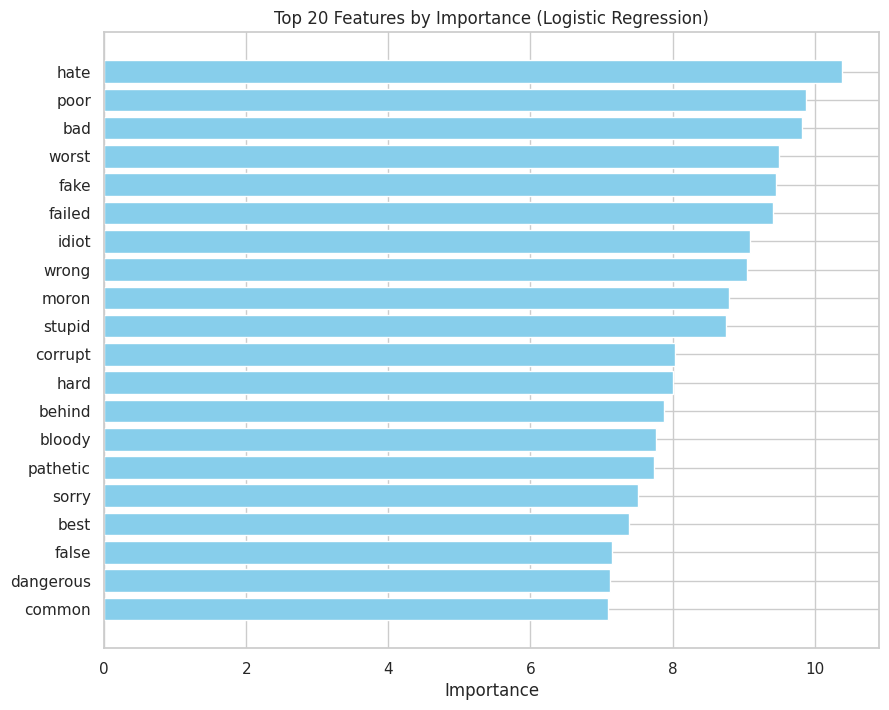

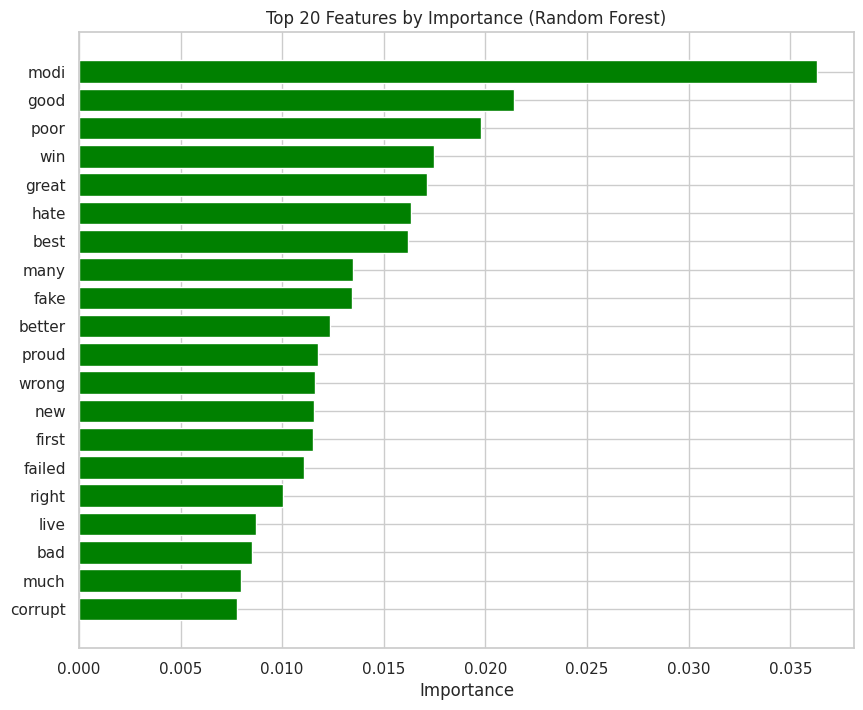

In [ ]:
# Logistic Regression - Feature Importance
if 'logistic_model' in globals() and isinstance(logistic_model, LogisticRegression):
    # Get feature names from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefficients = logistic_model.coef_[0]

    # Create a DataFrame to hold feature names and their importance
    feature_importance_logistic = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients)
    })

    # Sort by importance
    feature_importance_logistic = feature_importance_logistic.sort_values(by='Importance', ascending=False)

    # Select the top 20 features
    top_features_logistic = feature_importance_logistic.head(20)

    # Plot important features for Logistic Regression
    plt.figure(figsize=(10, 8))
    plt.barh(top_features_logistic['Feature'], top_features_logistic['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 20 Features by Importance (Logistic Regression)')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.show()

# Random Forest - Feature Importance
if 'rf_model' in globals() and isinstance(rf_model, RandomForestClassifier):
    # Get feature names from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get feature importance from the Random Forest model
    feature_importance_rf = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    })

    # Sort by importance
    feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

    # Select the top 20 features
    top_features_rf = feature_importance_rf.head(20)

    # Plot important features for Random Forest
    plt.figure(figsize=(10, 8))
    plt.barh(top_features_rf['Feature'], top_features_rf['Importance'], color='green')
    plt.xlabel('Importance')
    plt.title('Top 20 Features by Importance (Random Forest)')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.show()


In [ ]:
#Salva tutto in unico file
y_test_pred = logistic_model.predict(tfidf_vectorizer.transform(test['Post Content']))

test_results = test.copy()
test_results['Sentiment Type'] = y_test_pred

test_results[['Post ID', 'Post Content', 'Sentiment Type']].to_csv('test_predictions_logistic.csv', index=False)


y_test_pred_rf = rf_model.predict(tfidf_vectorizer.transform(test['Post Content']))

test_results = test.copy()
test_results['Sentiment Type'] = y_test_pred_rf

test_results[['Post ID', 'Post Content', 'Sentiment Type']].to_csv('test_predictions_rf.csv', index=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 256 out of 256 | elapsed:    0.2s finished


In [ ]:
import joblib
# model = trained logistic regression model
# tfidf = trained TF-IDF vectorizer

# Save the logistic model and the TF-IDF vectorizer
joblib.dump(logistic_model, 'sentiment_modelLogistic.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizeLogisticr.pkl')


# Save the random forest model and the TF-IDF vectorizer
joblib.dump(rf_model, 'sentiment_model_randomForest.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_randomForest.pkl')